In [1]:
"""Perform CAS fragment construction 
"""
import sys
sys.path.append("../")
import pickle
import io

import saveload_utils as sl
import ferm_utils as feru
import csa_utils as csau
import var_utils as varu
import openfermion as of
import numpy as np
import copy
import time 

# Parameters
mol = 'h4'
final_alpha = 1 
tol = 1e-8

# Get two-body tensor
Hf = sl.load_fermionic_hamiltonian(mol)
_, gs = of.linalg.get_ground_state(of.linalg.get_sparse_operator(Hf))
spin_orb = of.count_qubits(Hf)  
spatial_orb = spin_orb // 2
Htbt = feru.get_chemist_tbt(Hf, spin_orb, spin_orb = True)
one_body = varu.get_one_body_correction_from_tbt(Hf, feru.get_chemist_tbt(Hf))
# feru.get_one_body_terms(Hf)
# varu.get_one_body_correction_from_tbt(Hf, Htbt)


onebody_matrix = feru.get_obt(one_body, n = spin_orb, spin_orb = True)
onebody_tbt = feru.onebody_to_twobody(onebody_matrix)
# print(onebody_tbt.shape)
# print(Htbt.shape)

Htbt = np.add(Htbt, onebody_tbt)
recombined = feru.get_ferm_op(Htbt, True)
print("Initial Norm: {}".format(np.sum(Htbt * Htbt)))




Initial Norm: 24.72369480365834


(64, 64)
[[1.75238729 0.         0.         ... 0.         0.         0.26147612]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.07869102 ... 0.07531673 0.         0.        ]
 ...
 [0.         0.         0.07531673 ... 0.08123224 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.26147612 0.         0.         ... 0.         0.         0.91957409]]


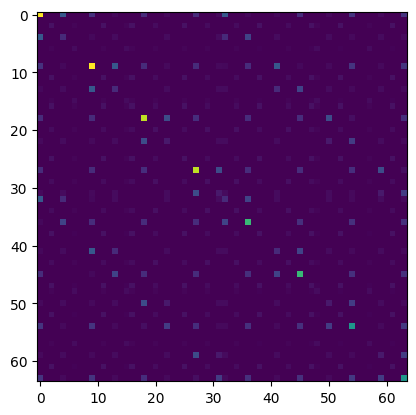

In [39]:
# print(feru.normal_ordered(Hf - recombined))
visual = Htbt.reshape(spin_orb **2, spin_orb ** 2)
visual = np.absolute(visual)
print(visual.shape)
print(visual)
from scipy import sparse
from matplotlib.pyplot import imshow
# print(sparse.csr_matrix(visual))
import numpy as np
# data = np.random.random((10,10))
# for i in Htbt:
#     for j in i:
imshow(visual)

In [4]:
k = [[0,1],[2,3],[4,5],[6,7]]
sol = csau.csa(Htbt,k = k, alpha=1, tol=tol, grad=True)
cur_tbt = csau.sum_cartans(sol.x, spin_orb, k, alpha=1, complex=False)
two_norm = np.sum((Htbt - cur_tbt) * (Htbt - cur_tbt))

print("two norm: " + str(two_norm))
relative_norm = two_norm / np.sum(Htbt * Htbt)
print("relative norm: " + str(relative_norm))



# print(np.real(var))


# print(planted_H)

         Current function value: 3.608275
         Iterations: 145
         Function evaluations: 15531
         Gradient evaluations: 167
two norm: 3.6082751336276324
relative norm: 0.14594400886609066


D:\Dev Tools\Python\lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [40]:
checked_sol = csau.csa(cur_tbt,k = [[0,1,2],[3]], alpha=2, tol=tol, grad=True)
checked_tbt = csau.sum_cartans(checked_sol.x, spin_orb, k = [[0,1,2],[3]], alpha=2, complex=False)
checked_norm = np.sum((checked_tbt - cur_tbt) * (checked_tbt - cur_tbt))
print(checked_norm)

         Current function value: 0.142167
         Iterations: 66
         Function evaluations: 17888
         Gradient evaluations: 101
0.14216713328627056


D:\Dev Tools\Python\lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [14]:
planted_H = feru.get_ferm_op(cur_tbt, True) + of.FermionOperator("", Hf.terms[()])
sparse_H = of.linalg.get_sparse_operator(planted_H)
# print(gs.shape)
var = np.real(of.linalg.variance(sparse_H, gs))
print(var)
# print(sparse_H.shape)



0.021888756934053788


In [18]:
D_0 = of.linalg.eigenspectrum(Hf)
D_0.sort()
D_0
# D_0: Original Spectrum for H2 Hamiltonian
D_1 = np.real(of.linalg.eigenspectrum(planted_H))
D_1.sort()
# D_1
eigen_spectrum_norm = np.linalg.norm(D_1 - D_0)
print("D_0:")
print(D_0)
print("D_1:")
print(D_1)
print("L2 Norm: ")
print(eigen_spectrum_norm)
# D_1: Perturbed Spectrum from planted solution of first fragment of CAS-CAS Decomposition of H2

D_0:
[-2.16638745 -1.93375723 -1.93375723 -1.93375723 -1.8391142  -1.8391142
 -1.76282582 -1.76282582 -1.71949414 -1.71949414 -1.71949414 -1.64965789
 -1.62313803 -1.58052219 -1.58052219 -1.50902902 -1.50902902 -1.43769128
 -1.43769128 -1.43769128 -1.41150919 -1.41150919 -1.41150919 -1.41150919
 -1.3893201  -1.3893201  -1.33227536 -1.28852206 -1.28852206 -1.28482257
 -1.28482257 -1.28482257 -1.27796217 -1.27796217 -1.21465658 -1.21465658
 -1.21465658 -1.21465658 -1.21465658 -1.1652851  -1.1652851  -1.1476416
 -1.1476416  -1.1476416  -1.1476416  -1.14680435 -1.12709399 -1.12709399
 -1.12199766 -1.10598148 -1.10598148 -1.10598148 -1.08604083 -0.98577434
 -0.98577434 -0.98344034 -0.96744594 -0.96744594 -0.96744594 -0.96744594
 -0.94782264 -0.9439754  -0.9439754  -0.9439754  -0.94325028 -0.93665054
 -0.93665054 -0.93665054 -0.93665054 -0.89119058 -0.89119058 -0.86899789
 -0.86899789 -0.83377717 -0.83377717 -0.83377717 -0.79301364 -0.79301364
 -0.77953522 -0.77953522 -0.77953522 -0.77113896

In [19]:
eigenSpectrum = of.linalg.eigenspectrum(Hf)
print([two_norm,relative_norm,var,eigen_spectrum_norm])

[3.6082751336276324, 0.14594400886609066, 0.021888756934053788, 53.77725061721891]


In [1]:
def partitions(n: int):
    """
    Return the all possible partition of the number n.
    """
    # base case of recursion: zero is the sum of the empty list
    if n == 0:
        yield []
        return
    
    # modify partitions of n-1 to form partitions of n
    for p in partitions(n-1):
        yield [1] + p
        if p and (len(p) < 2 or p[1] > p[0]):
            yield [p[0] + 1] + p[1:]

def partition_to_orbitals(partition: list[int]) -> list:
    """
    Return a orbital partitions from number partition of the total number of spin orbitals
    >>> partition_to_orbitals([2,2])
    [[0, 1], [2, 3]]
    >>> partition_to_orbitals([3,2,2])
    [[0, 1, 2], [3, 4], [5, 6]]
    """
    lis = [list(range(0+sum(partition[:i]),partition[i]+sum(partition[:i]))) for i in range(len(partition))]
    return lis

def valid_orbital_partitions(n: int) -> list[list[int]]:
    """
    Return the valid CAS orbital partitions with the number of spin orbitals n. 
    A partition is valid if it has more than one block and each block has at least 2 orbitals
    """     
    valid_partition = [i for i in list(partitions(n)) if min(i) > 1 and max(i) < n]
    valid_orbitals =[partition_to_orbitals(i) for i in valid_partition]
    return valid_orbitals
    
    
print(valid_orbital_partitions(12))


[[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]], [[0, 1], [2, 3], [4, 5], [6, 7, 8], [9, 10, 11]], [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]], [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9, 10, 11]], [[0, 1], [2, 3, 4], [5, 6, 7], [8, 9, 10, 11]], [[0, 1], [2, 3], [4, 5, 6, 7], [8, 9, 10, 11]], [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]], [[0, 1], [2, 3], [4, 5, 6], [7, 8, 9, 10, 11]], [[0, 1, 2], [3, 4, 5, 6], [7, 8, 9, 10, 11]], [[0, 1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11]], [[0, 1], [2, 3], [4, 5], [6, 7, 8, 9, 10, 11]], [[0, 1, 2], [3, 4, 5], [6, 7, 8, 9, 10, 11]], [[0, 1], [2, 3, 4, 5], [6, 7, 8, 9, 10, 11]], [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]], [[0, 1], [2, 3, 4], [5, 6, 7, 8, 9, 10, 11]], [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11]], [[0, 1], [2, 3], [4, 5, 6, 7, 8, 9, 10, 11]], [[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11]], [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10, 11]], [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]]


Comparing different Fragments to capture the Hamiltonian with two-body tensor form

In [6]:

title = ["2-norm of Difference in two-body tensor", "relative 2-norm", "Variance", "2-norm of eigenvalue spectrum"]
result = []
index = []

In [73]:
# print(len(index))
lis = []
for i in range(len(index)):
    lis += [[index[i]] + [str(round(s, 3)) for s in result[i]]]
# print(lis)
for i in lis:
    print(' & '.join(i) + "\\\\")

CSA & 0.155 & 0.03 & 0.034 & 0.523\\
CAS-CAS 2-2 & 0.928 & 0.178 & 0.034 & 3.208\\
CAS-CAS 3-1 & 0.716 & 0.137 & 0.005 & 2.259\\


In [55]:
import pandas as pd
print(result)
pd.DataFrame(result, columns = title, index = index)

[[0.15490613499420883, 0.029748091315936327, 0.03411211977760886, 0.5226331597591286], [0.9279447336117922, 0.17820201035070563, 0.034112118059972385, 3.2082428648410826], [0.7159496008105161, 0.13749057842877316, 0.005180975268052501, 2.2593083472282567]]


,2-norm of Difference in two-body tensor,relative 2-norm,Variance,2-norm of eigenvalue spectrum
CSA,0.154906,0.029748,0.034112,0.522633
CAS-CAS 2-2,0.927945,0.178202,0.034112,3.208243
CAS-CAS 3-1,0.715950,0.137491,0.005181,2.259308
